In [2]:
import os

audio_path = 'test/audio'
audio_files = os.listdir(audio_path)

In [3]:
import re

transcription = open('test/transcription.txt', 'r')
lines = transcription.readlines()

unformatted_transcripts = []
for line in lines:
    unformatted_transcripts.append(line.strip())


file1 = open("hinglish.txt", "r")
lines = file1.readlines()

hinglish_transcripts = []
for line in lines:
  #line = re.sub("\n", "", line)
  hinglish_transcripts.append(line.strip())

In [4]:
# processor
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

tokenizer = processor.tokenizer

def extract_all_chars(transcription_list):
    all_text = " ".join(transcription_list)
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


hindi_vocab = extract_all_chars(unformatted_transcripts)
hindi_vocab = set(hindi_vocab["vocab"][0])

/Users/kawaii/opt/miniconda3/envs/hindi_transcribe/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
hinglish_vocab = extract_all_chars(hinglish_transcripts)
hinglish_vocab = set(hinglish_vocab["vocab"][0])

In [6]:
# english vocab
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

In [7]:
formatted_transcripts = []

for transcript in unformatted_transcripts:
  trans = re.sub(r'\d+_\d+', '', transcript)
  
  formatted_transcripts.append(trans.strip())

print(len(formatted_transcripts))
formatted_transcripts_set = set(formatted_transcripts)
print(len(formatted_transcripts_set))

3843
386


In [8]:
hinglish_dict = {}

for i in range(len(hinglish_transcripts)):
  hinglish_dict[list(formatted_transcripts_set)[i]] = hinglish_transcripts[i]

In [9]:
transcription_dict = {}

for transcription in unformatted_transcripts:
  audio_id = re.findall(r'\d+_\d+', transcription)[0]
  trans = re.sub(r'\d+_\d+', '', transcription)
  trans = ' '.join(trans.split())
  transcription_dict[audio_id] = trans

In [14]:
from scipy.signal import resample
from scipy.io import wavfile
from tqdm import tqdm
import re

import torch
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, audio_files_path, transcription_dict, unformatted_transcripts, formatted_transcripts, hinglish_dict):
        self.audio_files_path = audio_files_path
        self.audio_files = os.listdir(audio_files_path)
        self.transcription_dict = transcription_dict
        self.unformatted_transcripts = unformatted_transcripts
        self.formatted_transcripts = formatted_transcripts
        self.hinglish_dict = hinglish_dict

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        #get audio file
        audio_file = self.audio_files[idx]
        #get audio num
        audio_num = re.findall(r'\d+_\d+', audio_file)[0]
        #speaker id
        speaker_id = re.findall(r'\d+', audio_num)[1]
        #get transcription
        hindi_transcription = self.transcription_dict[audio_num]
        hinglish_transcription = self.hinglish_dict[hindi_transcription]

        #get audio
        sr, data = wavfile.read(f'test/audio/{audio_file}')

        audio_dict = {
            'data': data,
            'sr': sr
        }

        return audio_dict, speaker_id, hindi_transcription, hinglish_transcription

In [15]:
dataset = AudioDataset('test/audio', transcription_dict, unformatted_transcripts, formatted_transcripts, hinglish_dict)

In [16]:
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset, batch_size=1, shuffle=True) # multiple batch size leads to error

In [17]:
audio_dict, speaker_id, hindi_transcription, hinglish_transcription = next(iter(trainloader))

In [18]:
# speaker embedding
import os
import torch
import speechbrain
import torchaudio
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

/Users/kawaii/opt/miniconda3/envs/hindi_transcribe/lib/python3.8/site-packages/speechbrain/utils/checkpoints.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load

In [19]:
def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [36]:
def prepare_dataset(audio_dict, hinglish_transcript):
    audio = audio_dict

    example = processor(
        text = hinglish_transcript[0],
        audio_target = np.squeeze(audio_dict["data"]), 
        sampling_rate = 16000,
        return_attention_mask=False,
    )

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(np.squeeze(audio_dict["data"]))

    return example

In [37]:
audio_dict, speaker_id, hindi_transcription, hinglish_transcription = next(iter(trainloader))

In [38]:
import numpy as np
np.squeeze(audio_dict["data"]).shape


processed_example = prepare_dataset(audio_dict, hinglish_transcription)

/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_31587/3268537995.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))


In [39]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

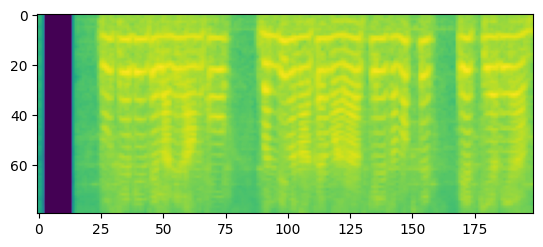

In [40]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [41]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [42]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [45]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=2000)